# Introduction

- Predictive maintenance on NASA's turbofan engine degradation dataset (CMAPSS). 
- Datasets include simulations of multiple turbofan engines over time, each row contains the following information:
  1. Engine unit number
  2. Time, in cycles
  3. Three operational settings
  4. 21 sensor readings.




# Importing Necessary Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option("display.max_rows", None)


# Importing the Dataset

In [2]:

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]

col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('train_FD001.txt',sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt',sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# Train data contains all features (Unit Number + setting parameters & sensor parameters)
# Test data contains all features (Unit Number + setting parameters & sensor parameters)
# Y_test contains RUL for the test data.
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
train.shape

(20631, 26)

In [4]:
y_test.shape

(100, 1)

In [5]:
train['unit_nr'].unique()

# There are 100 no unique engines.

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

Note:  for Test Dataset Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
therefore the test dataset will be subsetted to represent the same.

In [6]:
test.shape

(13096, 26)

In [7]:
# Since the true RUL values (y_test) for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
test = test.groupby('unit_nr').last().reset_index().drop(['unit_nr','time_cycles'], axis=1)

In [8]:
y_test.shape

# RUL value for 100 no of engines.

(100, 1)

In [9]:
test.shape
# Now test data contains entries for 100 no of engines with their RUL.

(100, 24)

# Data Pre-Processing + Data Visualization

In [10]:
train.describe()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [11]:
# Remove setting_3 column as we can see that it's value is not changing theerfore will not not add any information to our 
# prediction
train=train.drop('setting_3',axis=1)

In [12]:
# Adding RUL (Ramining Useful Life) to the train dataset

In [13]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[sensor_names+['RUL']].head()

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [14]:
train.head(5)

,unit_nr,time_cycles,setting_1,setting_2,s_1,s_2,s_3,s_4,s_5,s_6,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,518.67,641.82,1589.70,1400.60,14.62,21.61,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,518.67,642.15,1591.82,1403.14,14.62,21.61,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,518.67,642.35,1587.99,1404.20,14.62,21.61,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,518.67,642.35,1582.79,1401.87,14.62,21.61,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,518.67,642.37,1582.85,1406.22,14.62,21.61,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


## Plotting of RUL

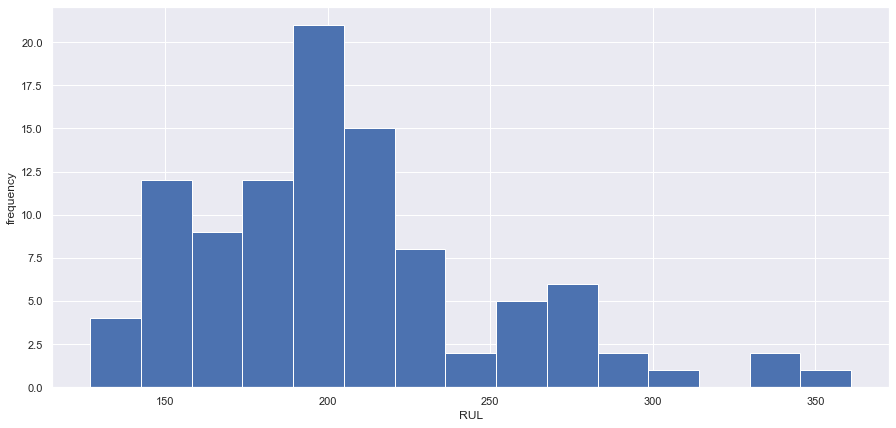

In [15]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

In [16]:
# We can see the RUL for engine is bit skewed on left side. This may affect perfomance of the model however as on 
# now we will keep it as it.


## Plotting of Sensor Values Vs RUL

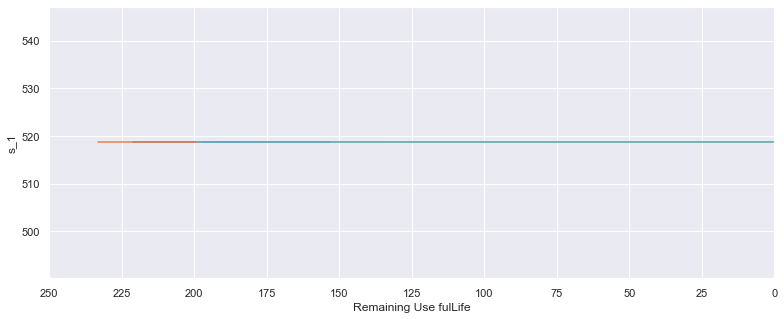

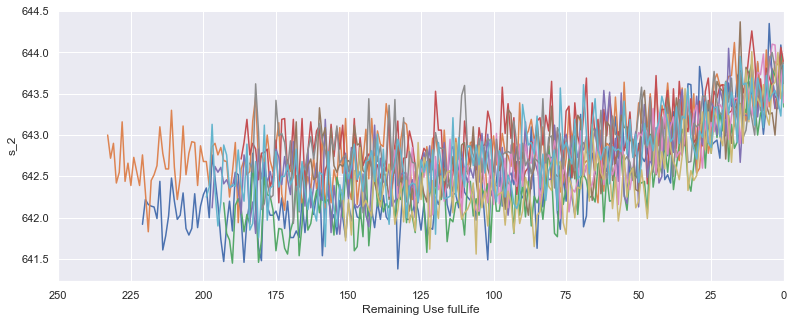

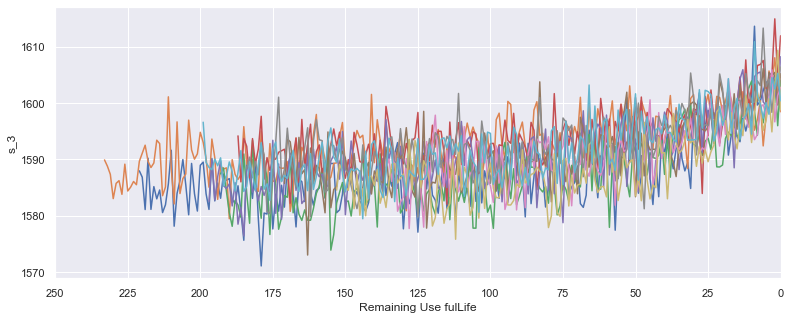

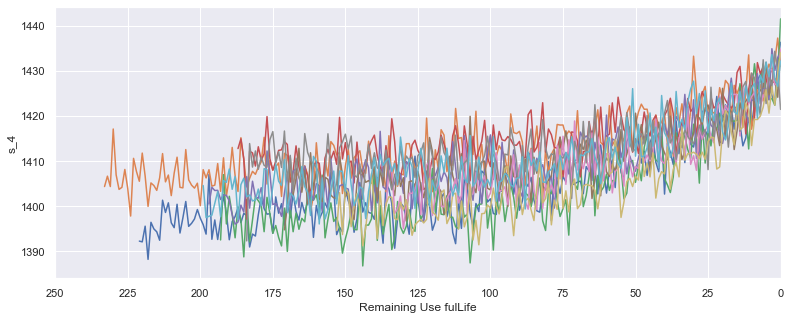

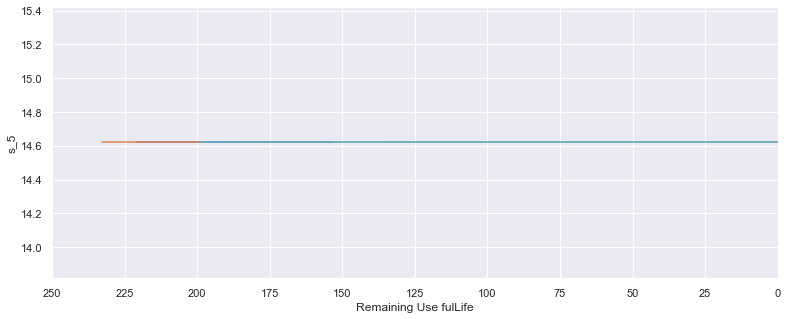

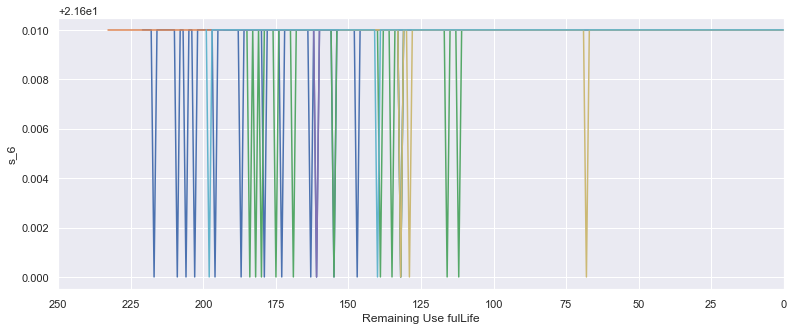

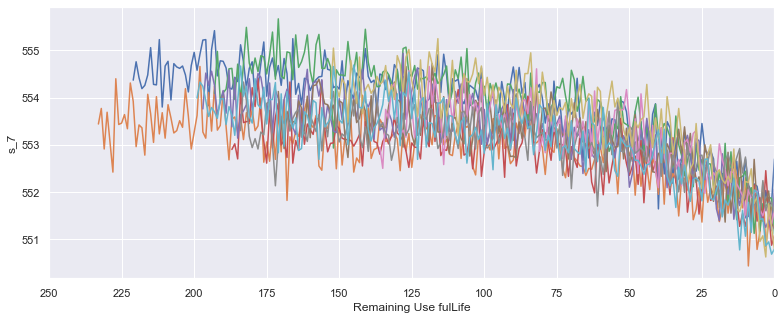

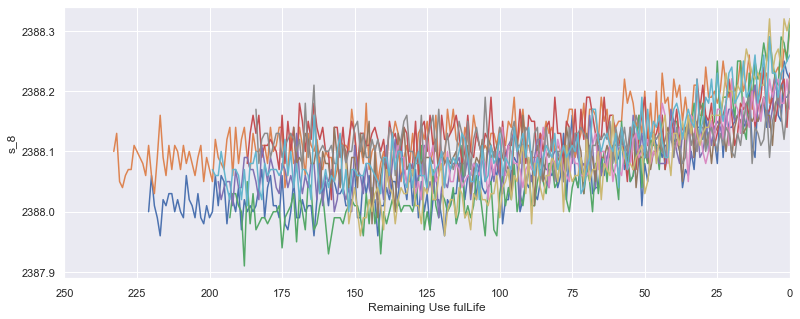

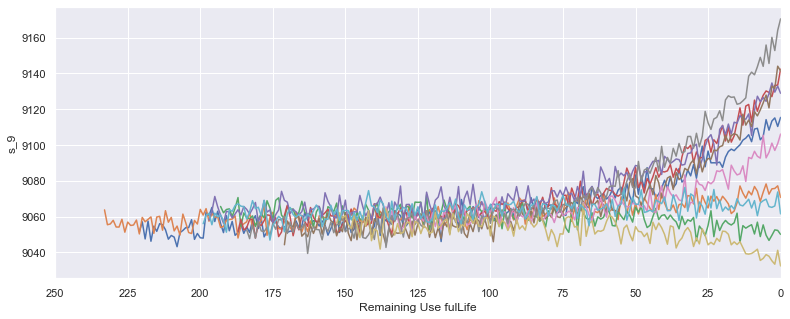

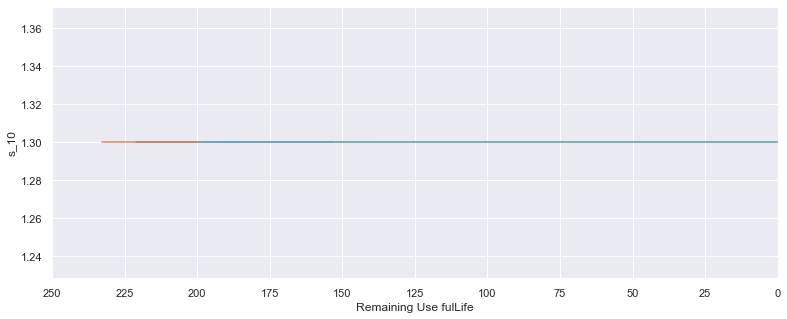

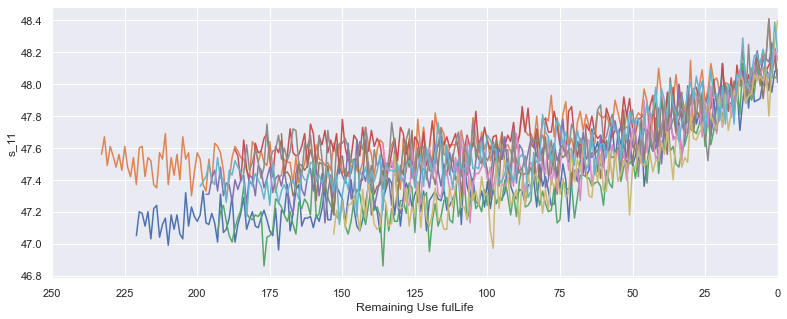

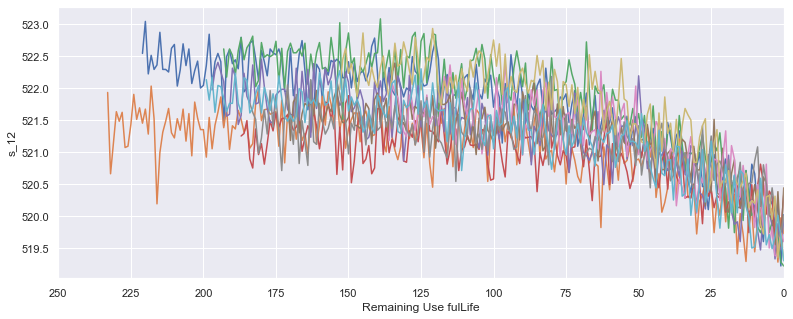

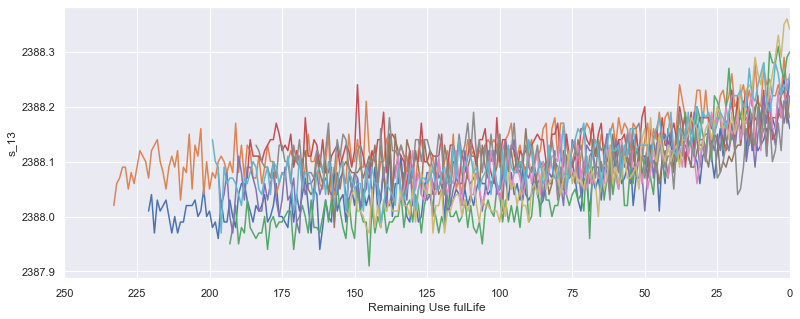

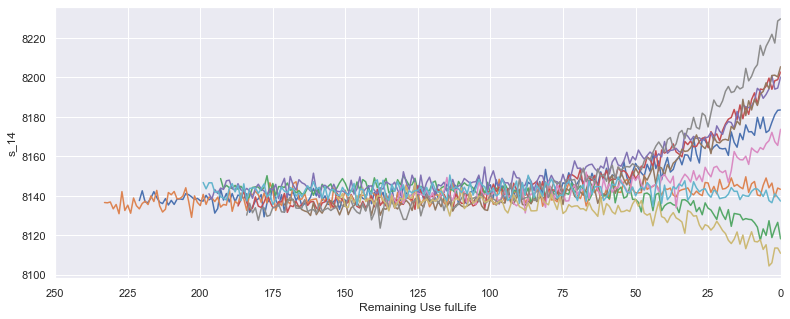

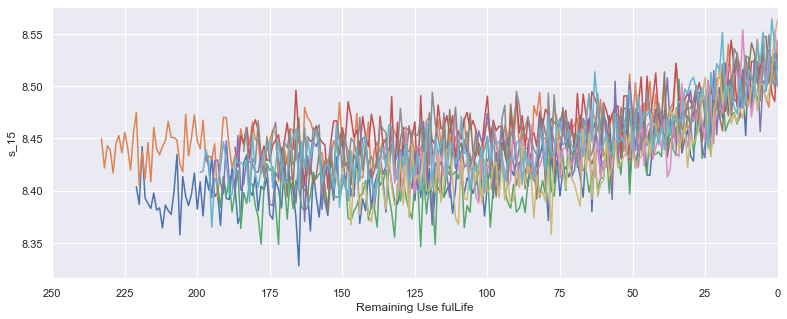

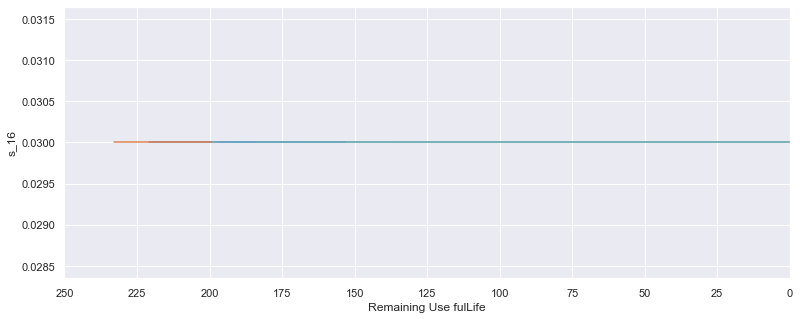

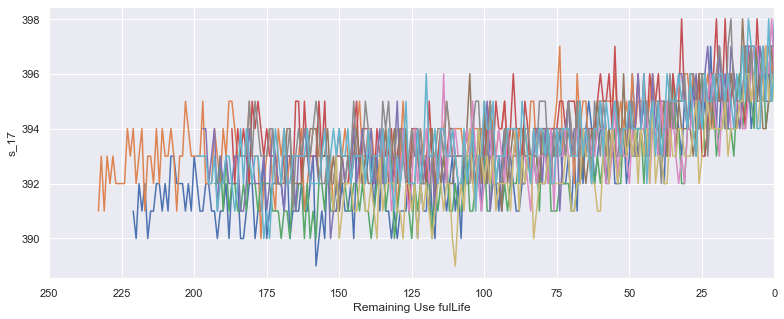

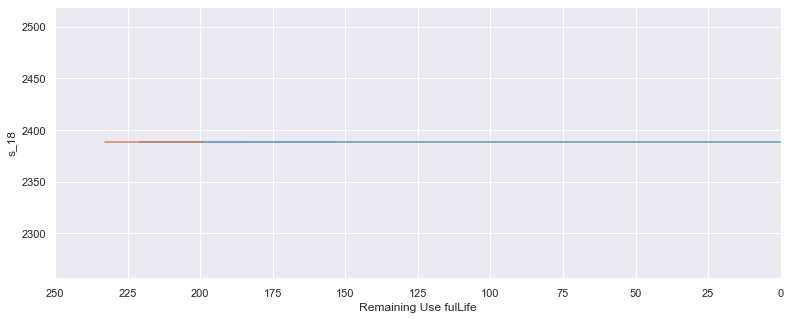

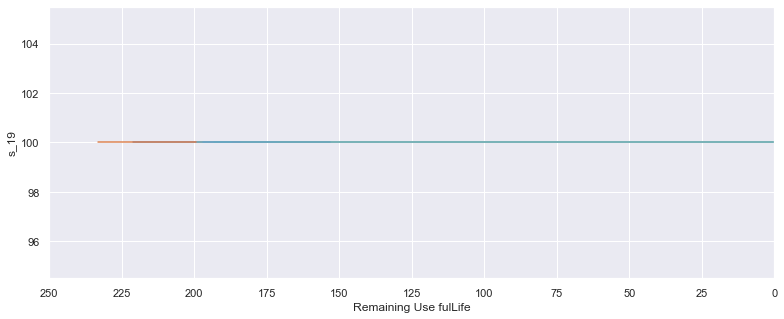

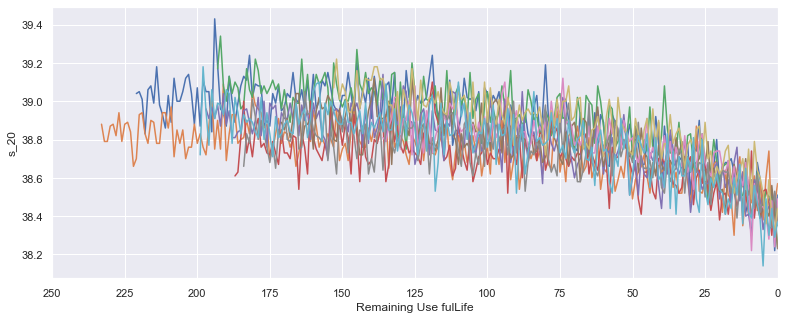

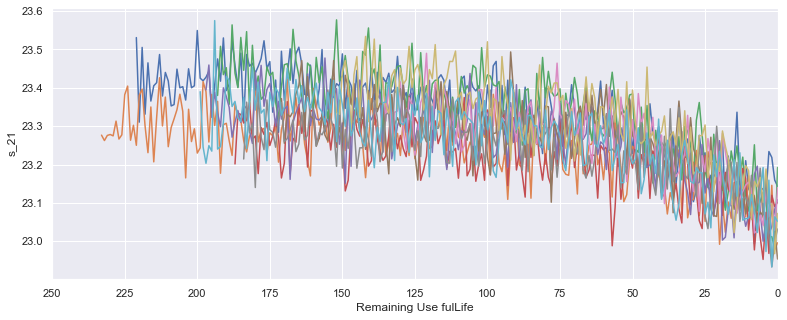

In [17]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

- Based on the plots you can see sensors 1, 5, 6, 10, 16, 18 and 19 hold no information related to Remaining Useful Life as the sensor values remain constant throughout time.
- As on now we will keep all features and will remove non-important features after calculating correlation value of each sensor variable with the RUL.

## Boxplots to find outliers

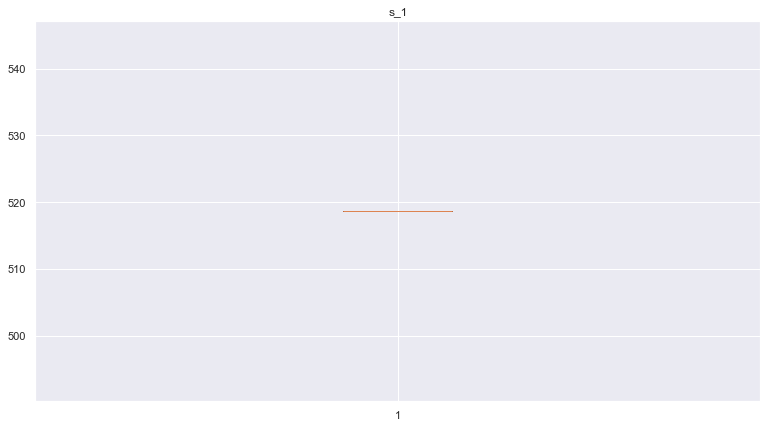

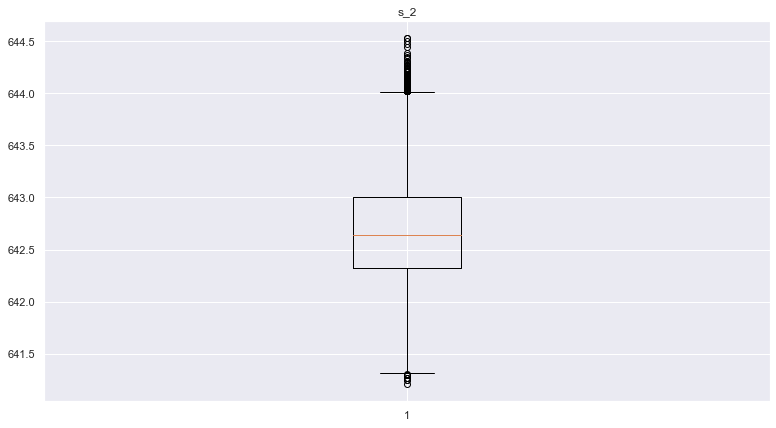

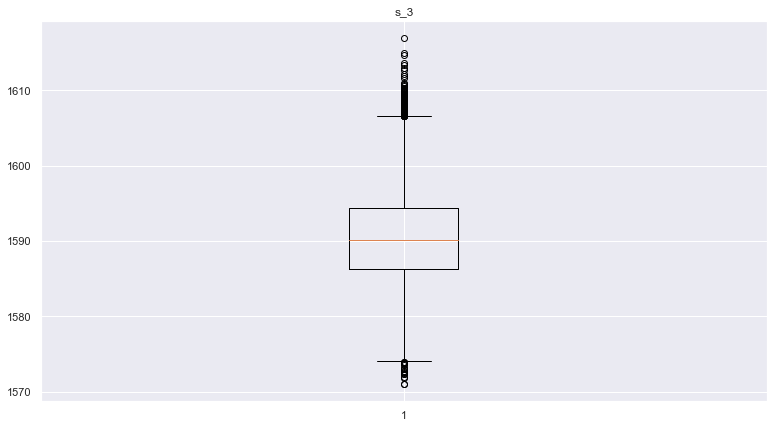

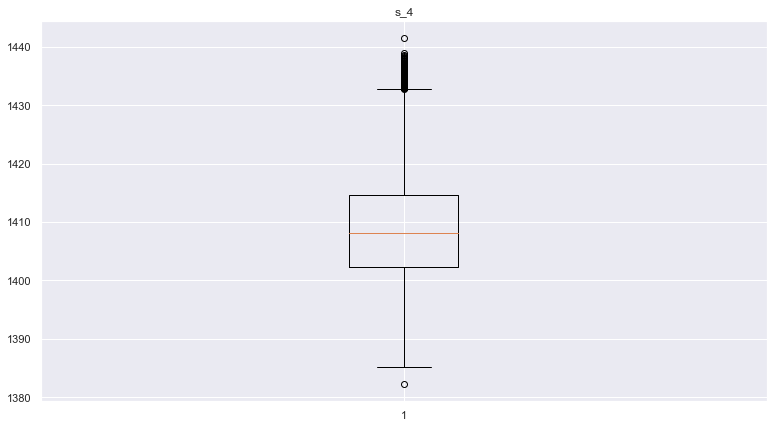

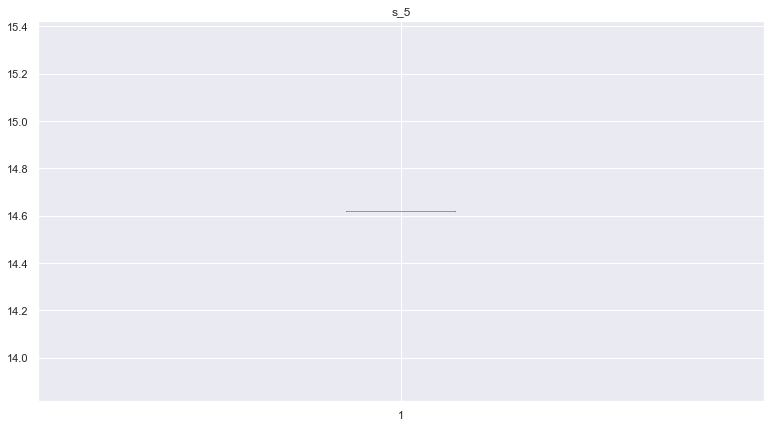

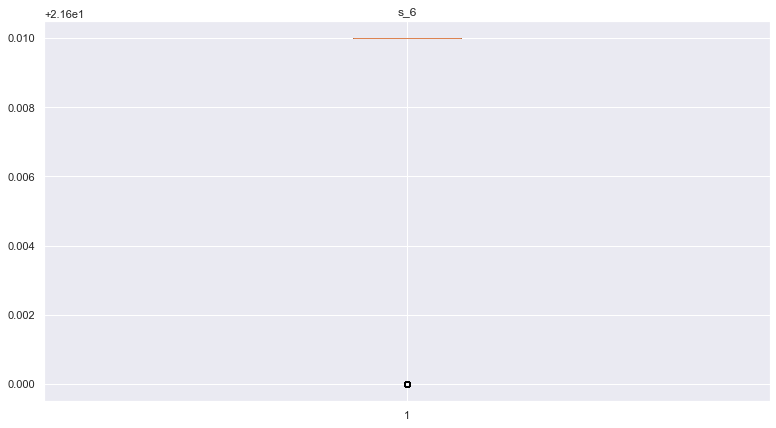

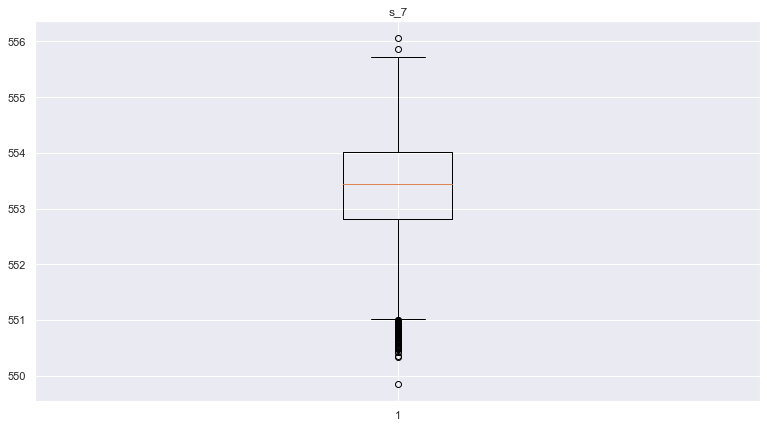

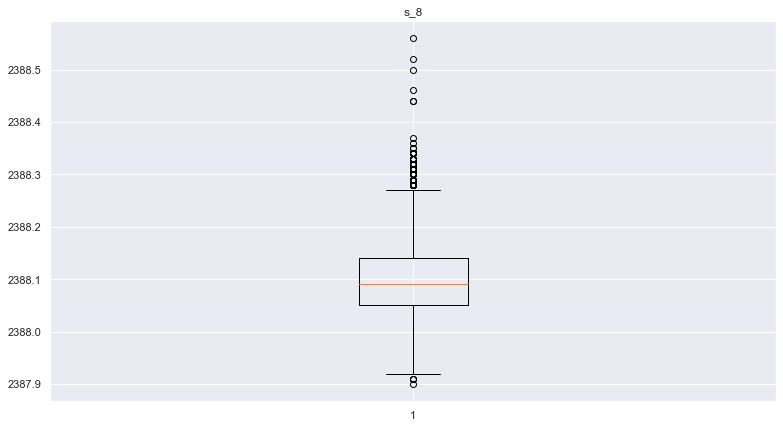

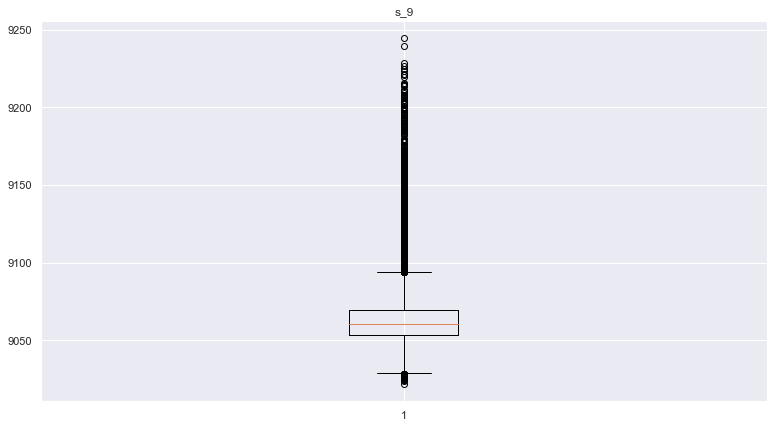

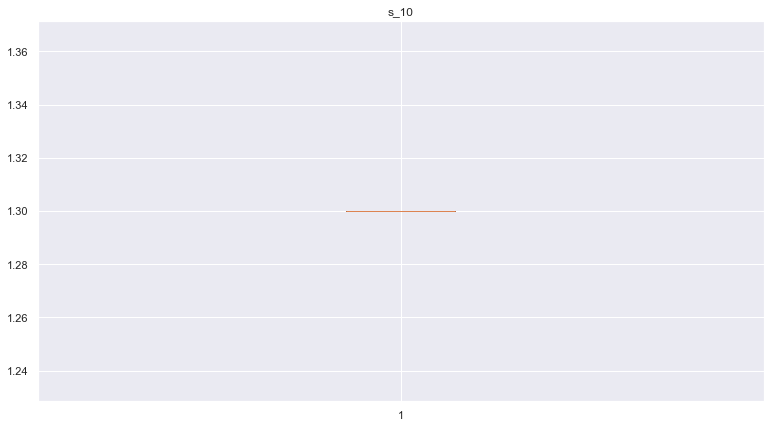

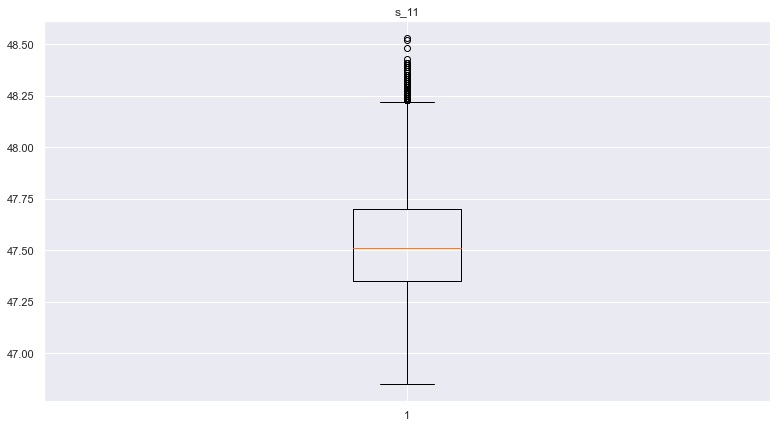

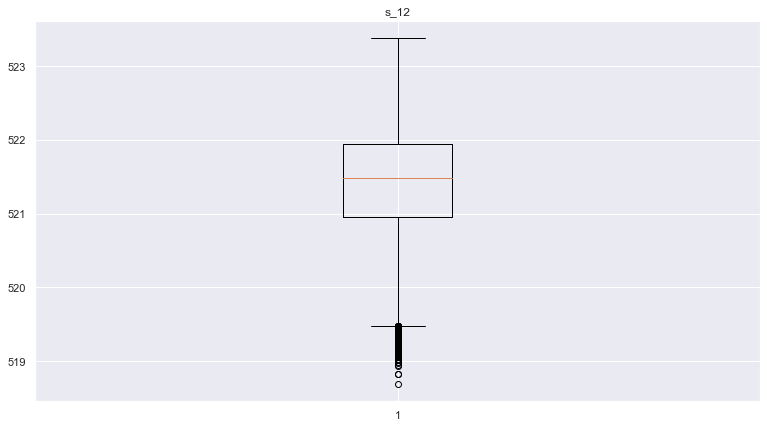

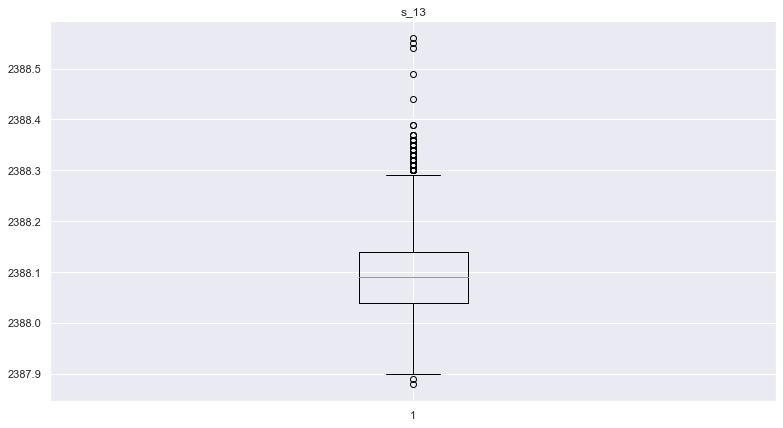

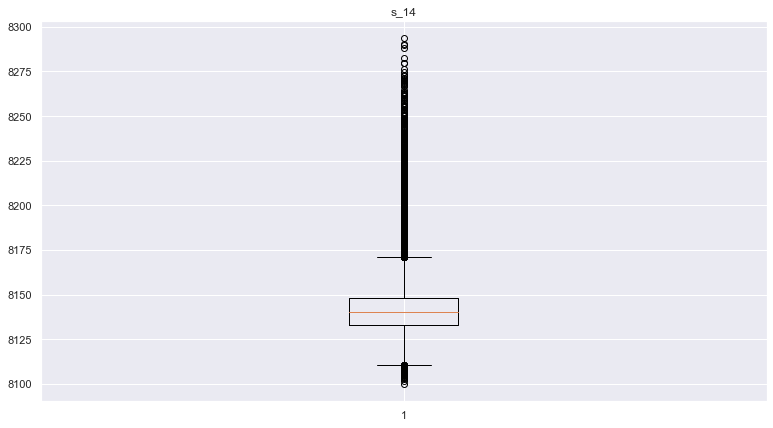

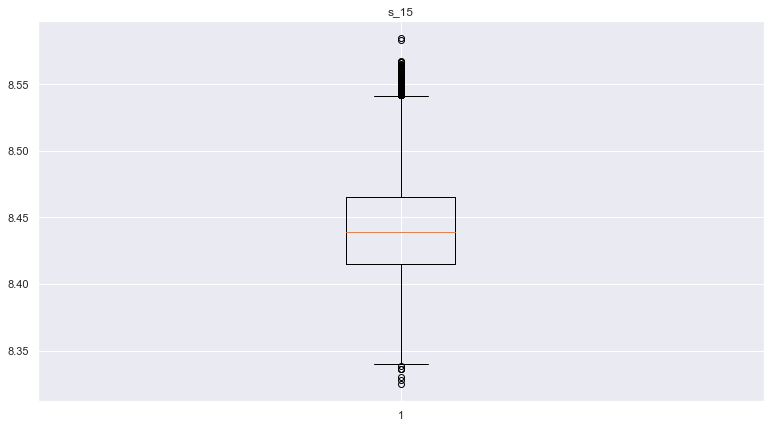

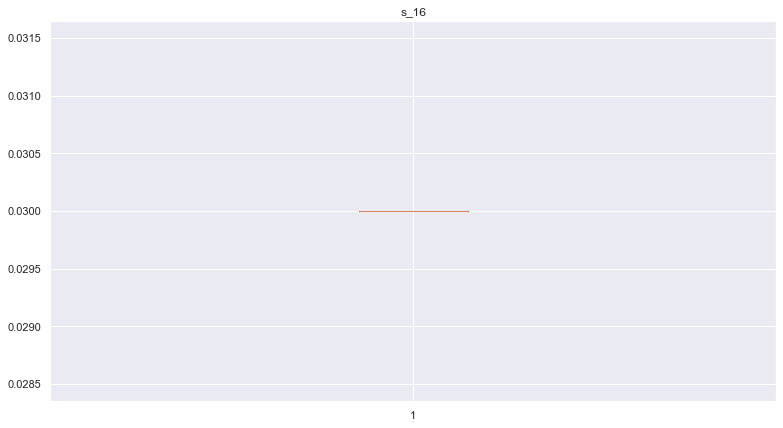

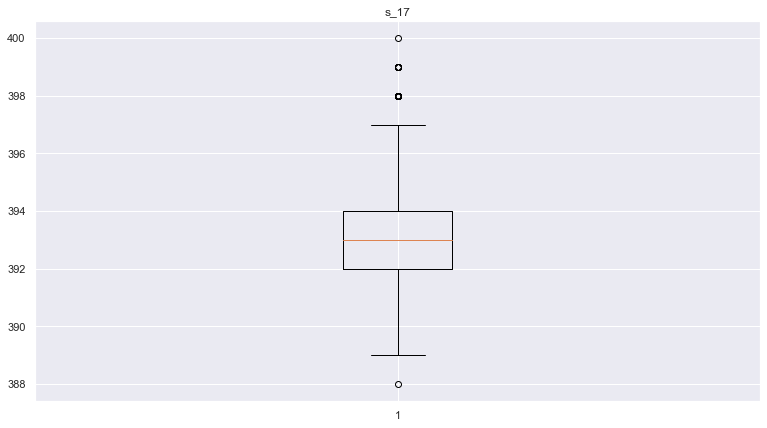

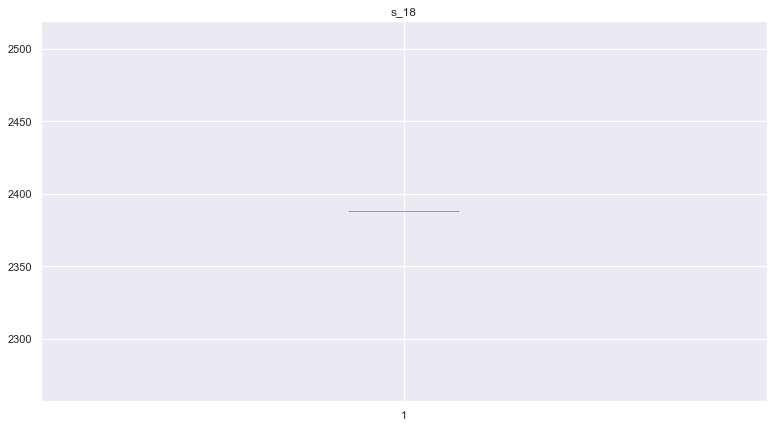

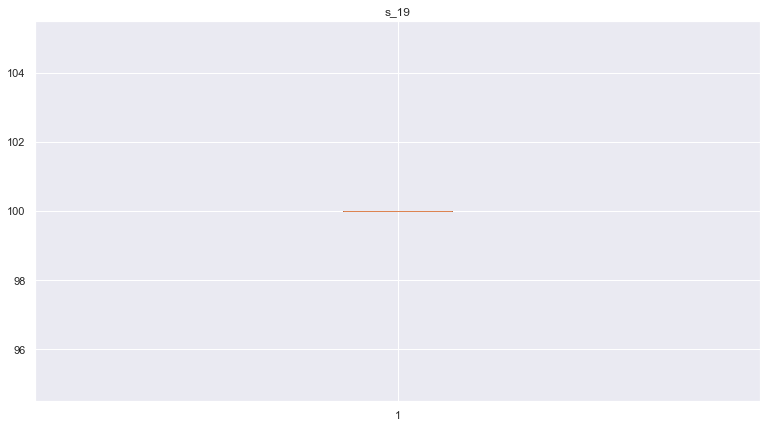

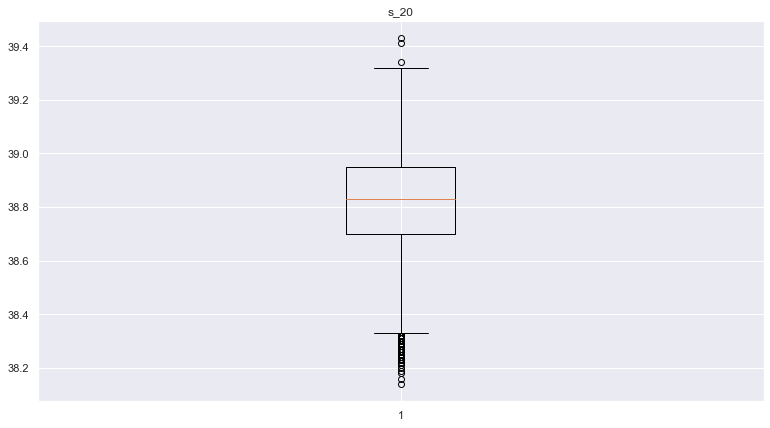

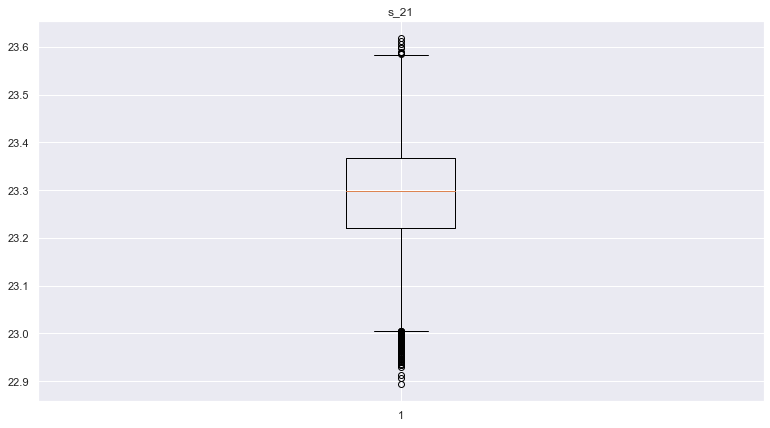

In [18]:
for x in sensor_names:
    plt.figure(figsize=(13,7))
    plt.boxplot(train[x])
    plt.title(x)
    plt.show()

## Max time cycle found for each Unit

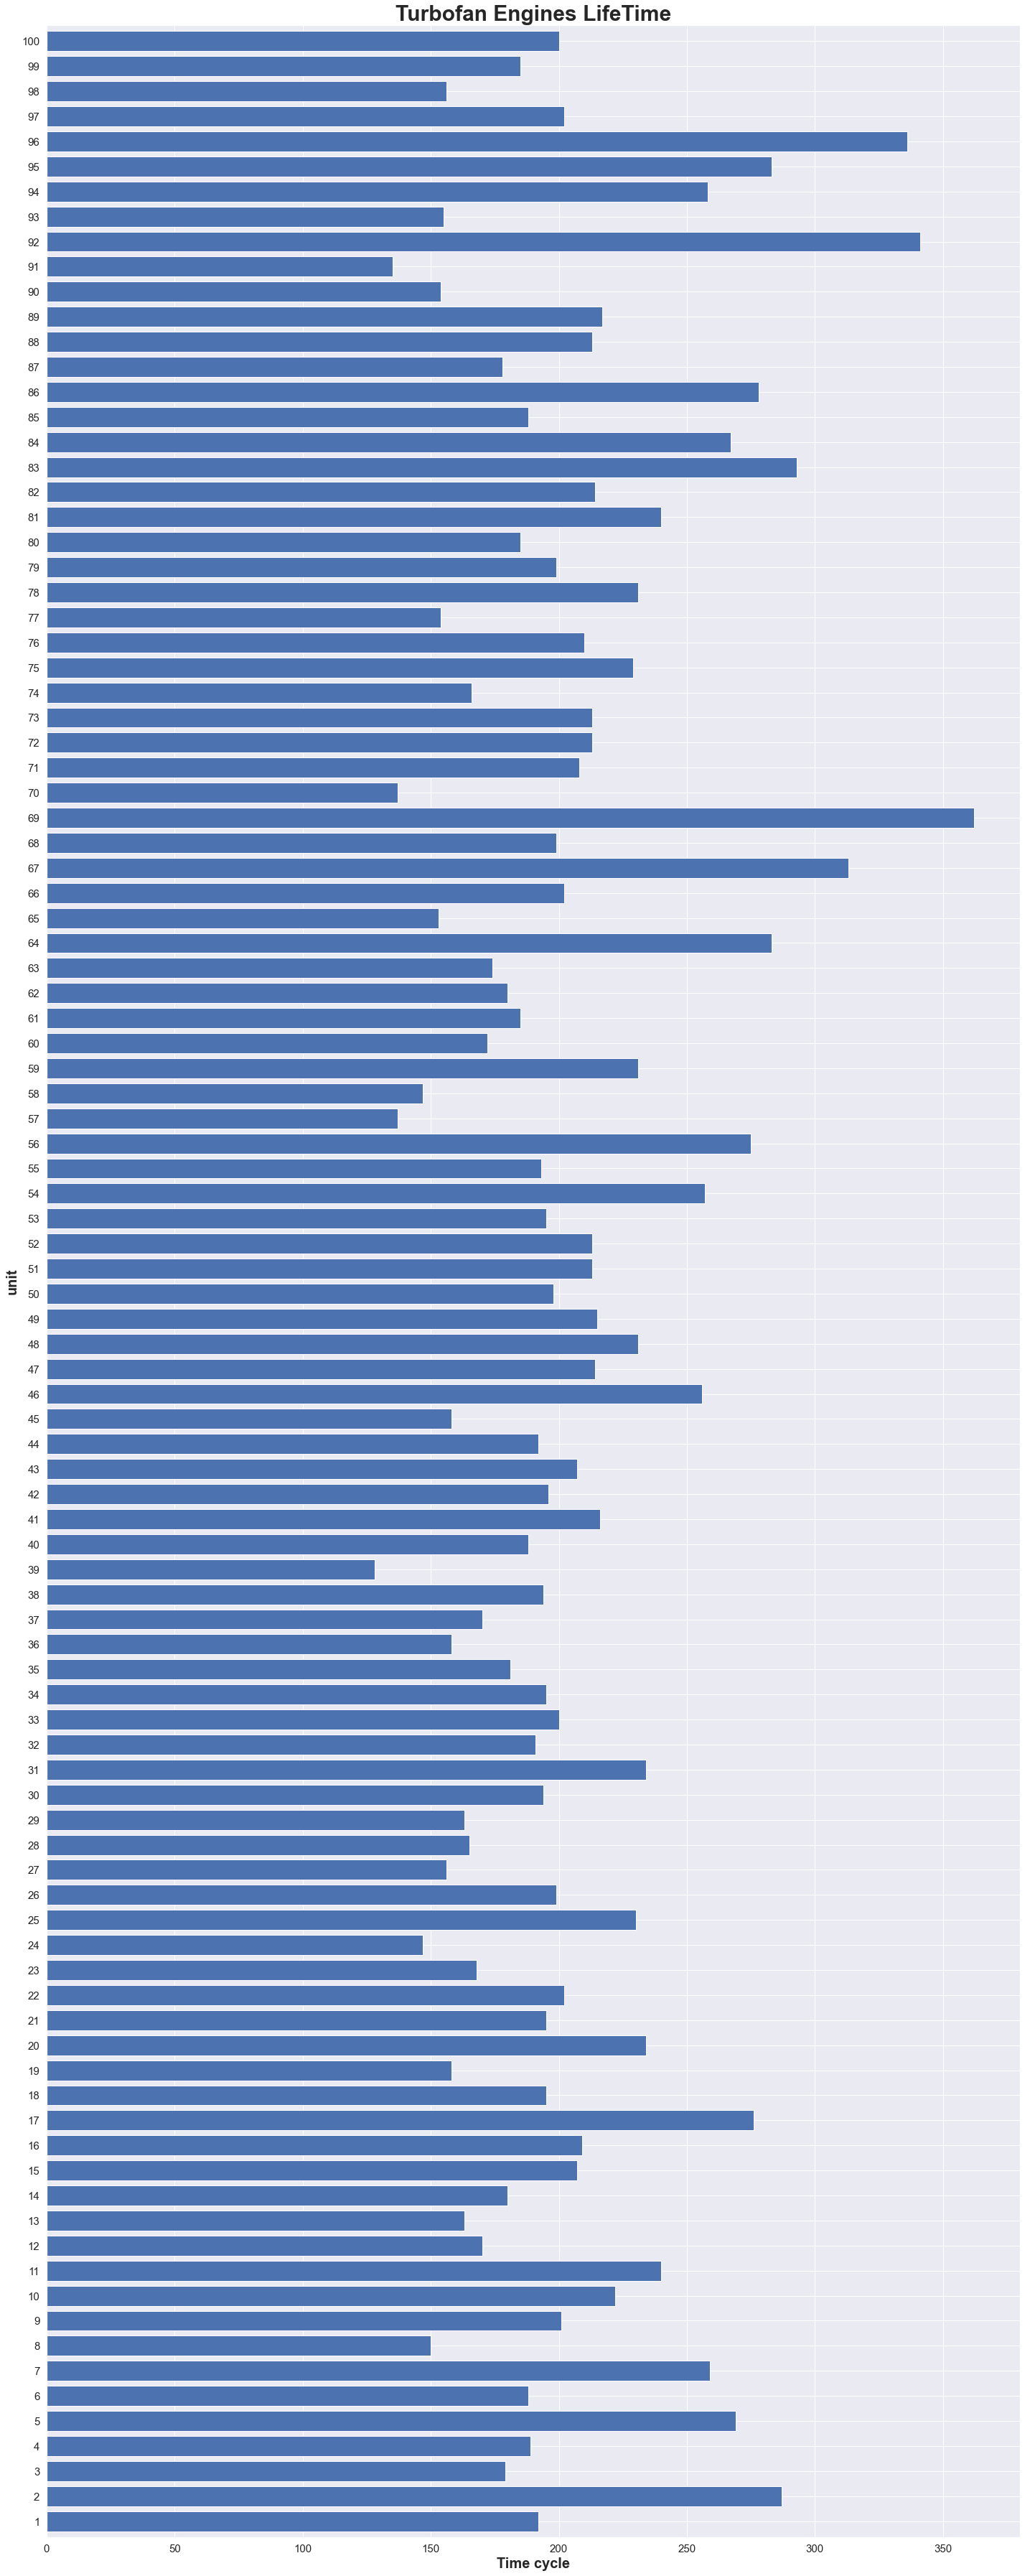

In [19]:
max_time_cycles=train[index_names].groupby('unit_nr').max()
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 8.959999999999994, 'max time cycle')

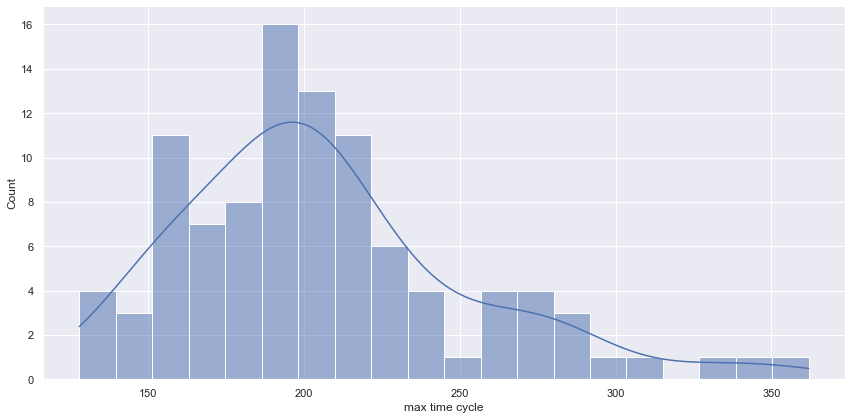

In [20]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

## Extraction of only Important Features which have strong relation affecting RUL of engine

In [21]:
# This is done to select only important features for model building in order to avoid problem of " Overfitting".

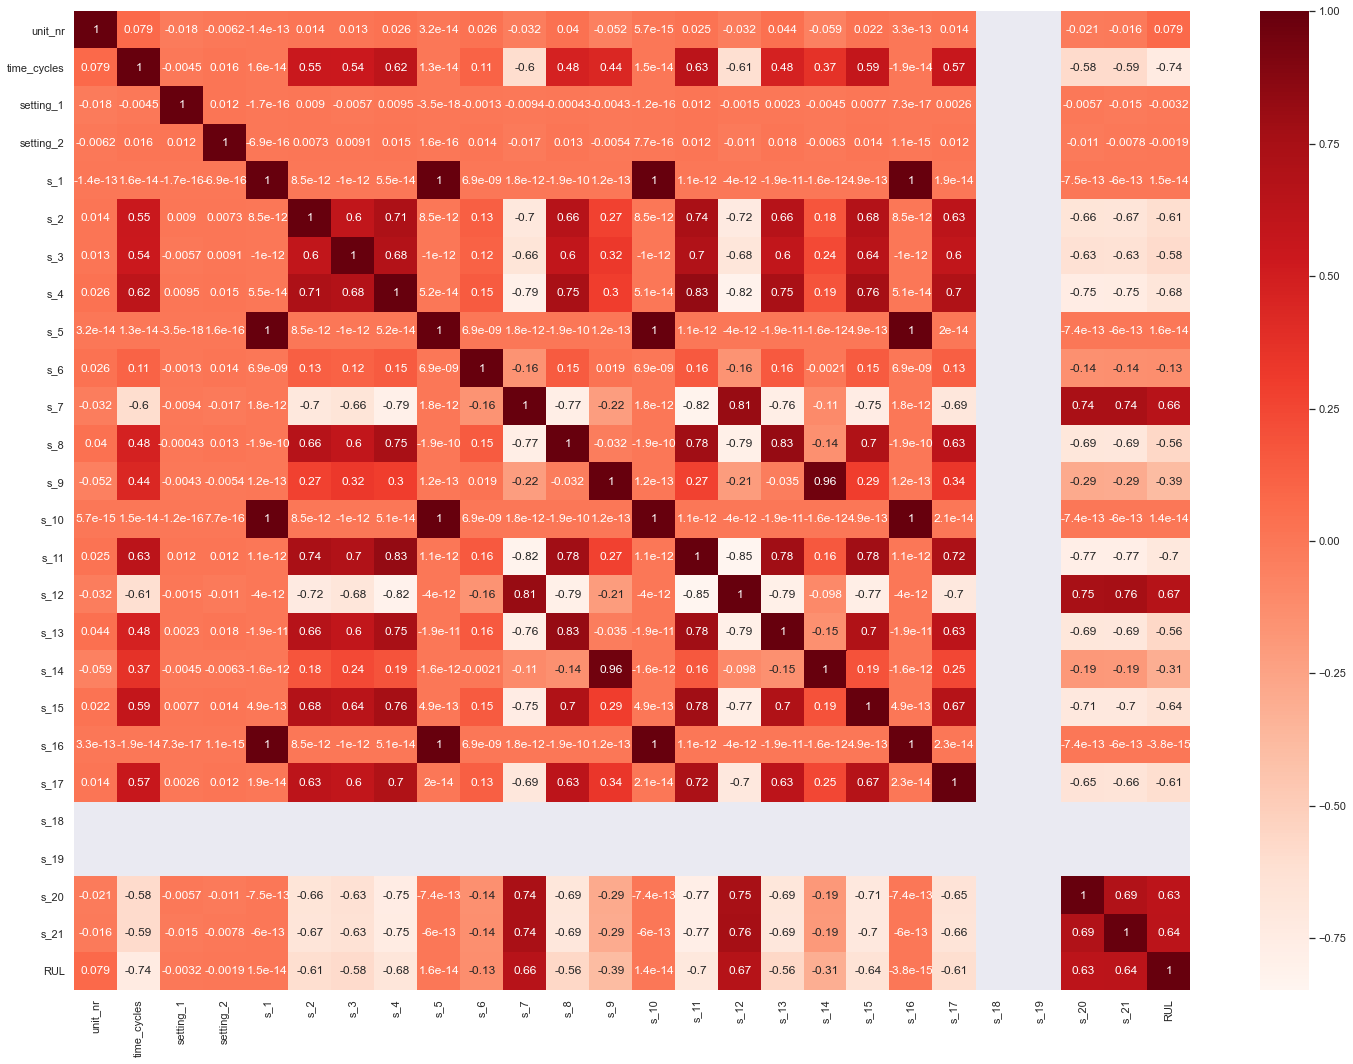

In [22]:
plt.figure(figsize=(25,18))
sns.heatmap(train.corr(),annot=True ,cmap='Reds')
plt.show()

In [23]:
cor=train.corr()
#cor_target = abs(cor["RUL"])
#Selecting highly correlated features
train_relevant_features = cor[abs(cor['RUL'])>=0.5]

train_relevant_features['RUL']

time_cycles   -0.736241
s_2           -0.606484
s_3           -0.584520
s_4           -0.678948
s_7            0.657223
s_8           -0.563968
s_11          -0.696228
s_12           0.671983
s_13          -0.562569
s_15          -0.642667
s_17          -0.606154
s_20           0.629428
s_21           0.635662
RUL            1.000000
Name: RUL, dtype: float64

In [24]:
list_relevant_features=train_relevant_features.index
list_relevant_features=list_relevant_features[1:]
list_relevant_features

Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_11', 's_12', 's_13', 's_15',
       's_17', 's_20', 's_21', 'RUL'],
      dtype='object')

In [25]:
# Above list contains important features have correlation of magnitude greater and equal to 0.5 with our target variable RUL.

In [26]:
# Now we will keep onlt these imprtant features in both train & test dataset.
train=train[list_relevant_features]

In [27]:
train.head(5)

,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21,RUL
0,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


array([[<AxesSubplot:title={'center':'s_2'}>,
        <AxesSubplot:title={'center':'s_3'}>,
        <AxesSubplot:title={'center':'s_4'}>],
       [<AxesSubplot:title={'center':'s_7'}>,
        <AxesSubplot:title={'center':'s_8'}>,
        <AxesSubplot:title={'center':'s_11'}>],
       [<AxesSubplot:title={'center':'s_12'}>,
        <AxesSubplot:title={'center':'s_13'}>,
        <AxesSubplot:title={'center':'s_15'}>],
       [<AxesSubplot:title={'center':'s_17'}>,
        <AxesSubplot:title={'center':'s_20'}>,
        <AxesSubplot:title={'center':'s_21'}>]], dtype=object)

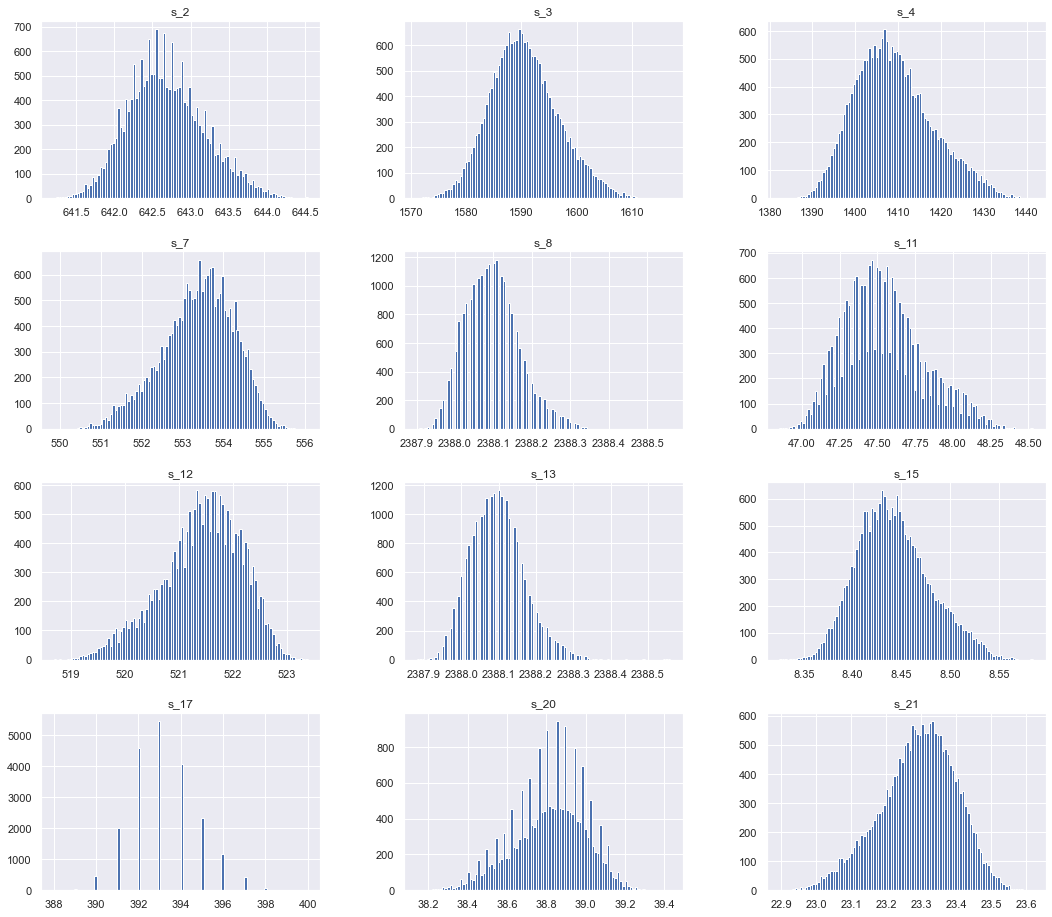

In [28]:
sensor_names=['s_{}'.format(i) for i in range(1,22) if i not in [1,5,6,9,10,14,16,18,19]]
pd.DataFrame(train,columns=['s_{}'.format(i) for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(18,16))

## Seperating Train & Test Data

In [29]:
# train & y_train
# Calculated RUL variable is our Target variable.
y_train=train['RUL']
X_train=train.drop(['RUL'],axis=1)
X_train.head(5)

,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21
0,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044


In [30]:
test.head(5)

,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,21.61,552.64,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,21.61,553.29,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117


In [31]:
# Test data set , keeping only train columns/features.
X_test=test[X_train.columns]
X_test.head(5)

,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21
0,642.58,1581.22,1398.91,554.42,2388.08,47.23,521.79,2388.06,8.4024,393,38.81,23.3552
1,642.55,1586.59,1410.83,553.52,2388.10,47.67,521.74,2388.09,8.4505,391,38.81,23.2618
2,642.88,1589.75,1418.89,552.59,2388.16,47.88,520.83,2388.14,8.4119,395,38.93,23.2740
3,642.78,1594.53,1406.88,552.64,2388.13,47.65,521.88,2388.11,8.4634,395,38.58,23.2581
4,642.27,1589.94,1419.36,553.29,2388.10,47.46,521.00,2388.15,8.4362,394,38.75,23.4117


In [32]:
y_test.head(5)

,RUL
0,112
1,98
2,69
3,82
4,91


In [33]:
y_train.describe()

count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

In [34]:
# Clipping of RUL at 125 as after 125 , RUL is responding to the sensor values after this value.
# This is done to improve performance of the applied models.

y_train= y_train.clip(upper=103)
y_train.head(5)

0    103
1    103
2    103
3    103
4    103
Name: RUL, dtype: int64

In [35]:
y_test.describe()

,RUL
count,100.00000
mean,75.52000
std,41.76497
min,7.00000
25%,32.75000
50%,86.00000
75%,112.25000
max,145.00000


In [36]:
y_test= y_test.clip(upper=86)
y_test.head(5)

,RUL
0,86
1,86
2,69
3,82
4,86


## Building Model

In [37]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse,variance;

## Bi-LSTM model

In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
# Model 8: Bidirectional LSTM
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [40]:
# Preprocess data for LSTM
scaler_lstm = StandardScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

In [41]:
# Reshape input for LSTM (assuming your data is sequential)
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))


In [42]:
# Build and train the Bidirectional LSTM model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
bilstm_model = build_bilstm_model(input_shape)


In [43]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [44]:
# Train the model
bilstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
516/516 [==============================] - 6s 4ms/step - loss: 4194.5181 - mae: 55.2690 - val_loss: 2298.5032 - val_mae: 38.7630
Epoch 2/50
516/516 [==============================] - 1s 2ms/step - loss: 1581.6086 - mae: 31.3180 - val_loss: 775.3013 - val_mae: 21.9364
Epoch 3/50
516/516 [==============================] - 1s 2ms/step - loss: 487.2161 - mae: 17.2245 - val_loss: 314.5794 - val_mae: 13.7484
Epoch 4/50
516/516 [==============================] - 1s 3ms/step - loss: 260.7447 - mae: 12.2789 - val_loss: 249.6272 - val_mae: 11.6094
Epoch 5/50
516/516 [==============================] - 1s 3ms/step - loss: 240.2153 - mae: 11.3665 - val_loss: 243.7257 - val_mae: 11.2324
Epoch 6/50
516/516 [==============================] - 1s 3ms/step - loss: 237.6447 - mae: 11.1984 - val_loss: 242.2302 - val_mae: 11.1120
Epoch 7/50
516/516 [==============================] - 2s 4ms/step - loss: 236.0750 - mae: 11.1212 - val_loss: 242.1218 - val_mae: 11.2174
Epoch 8/50
516/516 [===========

In [45]:
# Evaluate on train data
y_hat_train_lstm = bilstm_model.predict(X_train_lstm)
RMSE_Train_LSTM, R2_Train_LSTM = evaluate(y_train, y_hat_train_lstm, 'train')

645/645 [==============================] - 1s 1ms/step
train set RMSE:14.965069431680002, R2:0.7995646445533178


In [46]:
# Evaluate on test data
y_hat_test_lstm = bilstm_model.predict(X_test_lstm)
RMSE_Test_LSTM, R2_Test_LSTM = evaluate(y_test, y_hat_test_lstm, 'test')


4/4 [==============================] - 0s 4ms/step
test set RMSE:14.890731707699244, R2:0.7392206313863336


In [47]:
# Make Dataframe which will contain results of all applied Model
Results=pd.DataFrame({'Model': ['BiLSTM'],
    'RMSE-Train': [RMSE_Train_LSTM],
    'R2-Train': [R2_Train_LSTM],
    'RMSE-Test': [RMSE_Test_LSTM],
    'R2-Test': [R2_Test_LSTM]})
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.965069,0.799565,14.890732,0.739221


## Bi-TRNN model

In [48]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
# Model: Bidirectional Temporal Convolutional Network (Bi-TRNN)
def build_bitrnn_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(GRU(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [50]:
# Preprocess data for GRU
scaler_bitrnn = StandardScaler()
X_train_bitrnn = scaler_bitrnn.fit_transform(X_train)
X_test_bitrnn = scaler_bitrnn.transform(X_test)

In [51]:
# Reshape input for GRU (assuming your data is sequential)
X_train_bitrnn = X_train_bitrnn.reshape((X_train_bitrnn.shape[0], 1, X_train_bitrnn.shape[1]))
X_test_bitrnn = X_test_bitrnn.reshape((X_test_bitrnn.shape[0], 1, X_test_bitrnn.shape[1]))


In [52]:
# Build and train the Bidirectional GRU model
input_shape_bitrnn = (X_train_bitrnn.shape[1], X_train_bitrnn.shape[2])
bitrnn_model = build_bitrnn_model(input_shape_bitrnn)


In [53]:
# Define early stopping to prevent overfitting
early_stopping_bitrnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [54]:
# Train the model
bitrnn_model.fit(X_train_bitrnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bitrnn])


Epoch 1/50
516/516 [==============================] - 4s 3ms/step - loss: 3648.5200 - mae: 50.8283 - val_loss: 1528.2583 - val_mae: 31.4677
Epoch 2/50
516/516 [==============================] - 2s 4ms/step - loss: 676.2964 - mae: 19.8871 - val_loss: 275.8319 - val_mae: 12.8875
Epoch 3/50
516/516 [==============================] - 1s 3ms/step - loss: 242.4859 - mae: 11.7754 - val_loss: 246.5675 - val_mae: 11.5334
Epoch 4/50
516/516 [==============================] - 1s 3ms/step - loss: 235.2607 - mae: 11.3128 - val_loss: 242.3571 - val_mae: 11.3058
Epoch 5/50
516/516 [==============================] - 1s 3ms/step - loss: 232.5008 - mae: 11.1229 - val_loss: 241.2997 - val_mae: 11.1935
Epoch 6/50
516/516 [==============================] - 2s 4ms/step - loss: 229.7825 - mae: 11.0053 - val_loss: 236.4670 - val_mae: 10.9820
Epoch 7/50
516/516 [==============================] - 1s 3ms/step - loss: 227.2260 - mae: 10.8528 - val_loss: 237.9971 - val_mae: 11.2511
Epoch 8/50
516/516 [============

In [55]:
# Evaluate on train data
y_hat_train_bitrnn = bitrnn_model.predict(X_train_bitrnn)
RMSE_Train_BiTRNN, R2_Train_BiTRNN = evaluate(y_train, y_hat_train_bitrnn, 'train')


645/645 [==============================] - 1s 1ms/step
train set RMSE:14.910419958898531, R2:0.8010258721411835


In [56]:
# Evaluate on test data
y_hat_test_bitrnn = bitrnn_model.predict(X_test_bitrnn)
RMSE_Test_BiTRNN, R2_Test_BiTRNN = evaluate(y_test, y_hat_test_bitrnn, 'test')


4/4 [==============================] - 0s 2ms/step
test set RMSE:14.781698059463064, R2:0.7430256326565661


In [57]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['Bi-TRNN'],
    'RMSE-Train': [RMSE_Train_BiTRNN],
    'R2-Train': [R2_Train_BiTRNN],
    'RMSE-Test': [RMSE_Test_BiTRNN],
    'R2-Test': [R2_Test_BiTRNN]
}), ignore_index=True)


In [58]:
# Display the results DataFrame
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.965069,0.799565,14.890732,0.739221
1,Bi-TRNN,14.910420,0.801026,14.781698,0.743026


## Bi-GRU model

In [59]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping


In [60]:
# Model: Bidirectional GRU (Bi-GRU)
def build_bi_gru_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(GRU(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [61]:
# Preprocess data for GRU
scaler_bi_gru = StandardScaler()
X_train_bi_gru = scaler_bi_gru.fit_transform(X_train)
X_test_bi_gru = scaler_bi_gru.transform(X_test)


In [62]:
# Reshape input for GRU (assuming your data is sequential)
X_train_bi_gru = X_train_bi_gru.reshape((X_train_bi_gru.shape[0], 1, X_train_bi_gru.shape[1]))
X_test_bi_gru = X_test_bi_gru.reshape((X_test_bi_gru.shape[0], 1, X_test_bi_gru.shape[1]))


In [63]:
# Build and train the Bidirectional GRU model
input_shape_bi_gru = (X_train_bi_gru.shape[1], X_train_bi_gru.shape[2])
bi_gru_model = build_bi_gru_model(input_shape_bi_gru)


In [64]:
# Define early stopping to prevent overfitting
early_stopping_bi_gru = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [65]:
# Train the model
bi_gru_model.fit(X_train_bi_gru, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bi_gru])


Epoch 1/50
516/516 [==============================] - 4s 3ms/step - loss: 3600.0664 - mae: 50.4205 - val_loss: 1328.9236 - val_mae: 29.3750
Epoch 2/50
516/516 [==============================] - 1s 3ms/step - loss: 555.5342 - mae: 18.0549 - val_loss: 260.4879 - val_mae: 12.3182
Epoch 3/50
516/516 [==============================] - 2s 3ms/step - loss: 241.4276 - mae: 11.6871 - val_loss: 244.7331 - val_mae: 11.3853
Epoch 4/50
516/516 [==============================] - 1s 3ms/step - loss: 235.8582 - mae: 11.2954 - val_loss: 241.3382 - val_mae: 11.1659
Epoch 5/50
516/516 [==============================] - 1s 3ms/step - loss: 232.8010 - mae: 11.1190 - val_loss: 239.7119 - val_mae: 11.2185
Epoch 6/50
516/516 [==============================] - 1s 3ms/step - loss: 230.0884 - mae: 10.9830 - val_loss: 239.0294 - val_mae: 11.4289
Epoch 7/50
516/516 [==============================] - 1s 3ms/step - loss: 227.6865 - mae: 10.8960 - val_loss: 236.5577 - val_mae: 10.8210
Epoch 8/50
516/516 [============

In [66]:
# Evaluate on train data
y_hat_train_bi_gru = bi_gru_model.predict(X_train_bi_gru)
RMSE_Train_BiGRU, R2_Train_BiGRU = evaluate(y_train, y_hat_train_bi_gru, 'train')


645/645 [==============================] - 1s 1ms/step
train set RMSE:14.921605606166228, R2:0.8007272233777611


In [67]:
# Evaluate on test data
y_hat_test_bi_gru = bi_gru_model.predict(X_test_bi_gru)
RMSE_Test_BiGRU, R2_Test_BiGRU = evaluate(y_test, y_hat_test_bi_gru, 'test')


4/4 [==============================] - 0s 2ms/step
test set RMSE:14.84223574774229, R2:0.7409164717492103


In [68]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['BiGRU'],
    'RMSE-Train': [RMSE_Train_BiGRU],
    'R2-Train': [R2_Train_BiGRU],
    'RMSE-Test': [RMSE_Test_BiGRU],
    'R2-Test': [R2_Test_BiGRU]
}), ignore_index=True)


In [69]:
# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.965069,0.799565,14.890732,0.739221
1,Bi-TRNN,14.910420,0.801026,14.781698,0.743026
2,BiGRU,14.921606,0.800727,14.842236,0.740916


## Ensemble model using RDT(Regression Decision Tree)

In [70]:
# Concatenate predictions from ProgNet and BiGRU for training data
X_train_ensemble = np.concatenate((y_hat_train_lstm, y_hat_train_bitrnn, y_hat_train_bi_gru), axis=1)

# Concatenate predictions from ProgNet and BiGRU for test data
X_test_ensemble = np.concatenate((y_hat_test_lstm, y_hat_test_bitrnn,y_hat_test_bi_gru ), axis=1)


In [71]:
# Model : Regression Decision Tree (RDT)
rdt_model = DecisionTreeRegressor()

# Train the RDT model
rdt_model.fit(X_train_ensemble, y_train)


DecisionTreeRegressor()

In [72]:
# Predictions on training data
y_hat_train_ensemble = rdt_model.predict(X_train_ensemble)
RMSE_Train_Ensemble, R2_Train_Ensemble = evaluate(y_train, y_hat_train_ensemble, 'train')

# Predictions on test data
y_hat_test_ensemble = rdt_model.predict(X_test_ensemble)
RMSE_Test_Ensemble, R2_Test_Ensemble = evaluate(y_test, y_hat_test_ensemble, 'test')


train set RMSE:0.0, R2:1.0
test set RMSE:22.96715045450785, R2:0.37962343663612397


In [73]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['Ensemble (Bi-LSTM,Bi-trnn+ Bi-GRU )'],
    'RMSE-Train': [RMSE_Train_Ensemble],
    'R2-Train': [R2_Train_Ensemble],
    'RMSE-Test': [RMSE_Test_Ensemble],
    'R2-Test': [R2_Test_Ensemble]
}), ignore_index=True)

# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.965069,0.799565,14.890732,0.739221
1,Bi-TRNN,14.910420,0.801026,14.781698,0.743026
2,BiGRU,14.921606,0.800727,14.842236,0.740916
3,"Ensemble (Bi-LSTM,Bi-trnn+ Bi-GRU )",0.000000,1.000000,22.967150,0.379623


## Ensemble model using Random Forest Regressor

In [74]:
# Model : Random Forest (instead of Decision Tree)
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Train the Random Forest model
random_forest_model.fit(X_train_ensemble, y_train)

# Predictions on training data
y_hat_train_rf = random_forest_model.predict(X_train_ensemble)
RMSE_Train_RF, R2_Train_RF = evaluate(y_train, y_hat_train_rf, 'train')

# Predictions on test data
y_hat_test_rf = random_forest_model.predict(X_test_ensemble)
RMSE_Test_RF, R2_Test_RF = evaluate(y_test, y_hat_test_rf, 'test')

# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['Random Forest (Ensemble)'],
    'RMSE-Train': [RMSE_Train_RF],
    'R2-Train': [R2_Train_RF],
    'RMSE-Test': [RMSE_Test_RF],
    'R2-Test': [R2_Test_RF]
}), ignore_index=True)

# Display the results DataFrame
Results


train set RMSE:13.544305921825227, R2:0.8358161757130886
test set RMSE:14.469955961701336, R2:0.7537503791030443


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.965069,0.799565,14.890732,0.739221
1,Bi-TRNN,14.910420,0.801026,14.781698,0.743026
2,BiGRU,14.921606,0.800727,14.842236,0.740916
3,"Ensemble (Bi-LSTM,Bi-trnn+ Bi-GRU )",0.000000,1.000000,22.967150,0.379623
4,Random Forest (Ensemble),13.544306,0.835816,14.469956,0.753750


## Conclusion

In [75]:
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.965069,0.799565,14.890732,0.739221
1,Bi-TRNN,14.910420,0.801026,14.781698,0.743026
2,BiGRU,14.921606,0.800727,14.842236,0.740916
3,"Ensemble (Bi-LSTM,Bi-trnn+ Bi-GRU )",0.000000,1.000000,22.967150,0.379623
4,Random Forest (Ensemble),13.544306,0.835816,14.469956,0.753750


## Base Paper Result

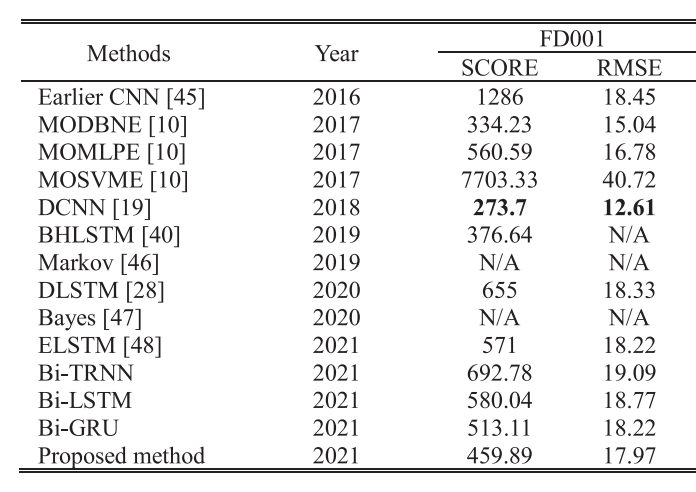